In [1]:
import math
import numpy as np
import torch
import matplotlib.pyplot as plt


In [2]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0
        self._backward = lambda: None

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        #print(f"Adding {self} and {other}")
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        #print(f"Multiplying {self} and {other}")
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        return self * other
    
    def __truediv__(self, other):
        return self * other**-1

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "supports int/float"
        out = Value(self.data**other, (self,), f'**{other}')
        def _backward():
            self.grad += (other*(self.data)**(other-1))*out.grad
        out._backward = _backward    
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(x: Value):
            if x not in visited:
                visited.add(x)
                for child in x._prev:
                    build_topo(child)
                topo.append(x)
        
        build_topo(self)
        for v in reversed(topo):
            v._backward()

In [3]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

    nodes, edges = trace(root)
    for n in nodes:
        vid = str(id(n))
        dot.node(name=vid, label = "{%s | grad %.4f | data %.4f}" % (n.label, n.grad,n.data), shape='record')
        if n._op:
            dot.node(name=vid+n._op, label=n._op)
            dot.edge(vid+n._op, vid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2))+n2._op)

    return dot


In [4]:
#x1 and x2 inputs
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')

#w1 and #w2 inputs
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')

b = Value(6.8813735870195433, label = 'b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

x1w1_x2w2 = x1w1 + x2w2; x1w1_x2w2.label = 'x1w1+x2w2'
n = x1w1_x2w2 + b; n.label = 'n' 
#--------------
e = (2*n).exp()
o = (e - 1) / (e + 1)
#--------------
o.grad=1.0; o.label = 'o'
o.backward()


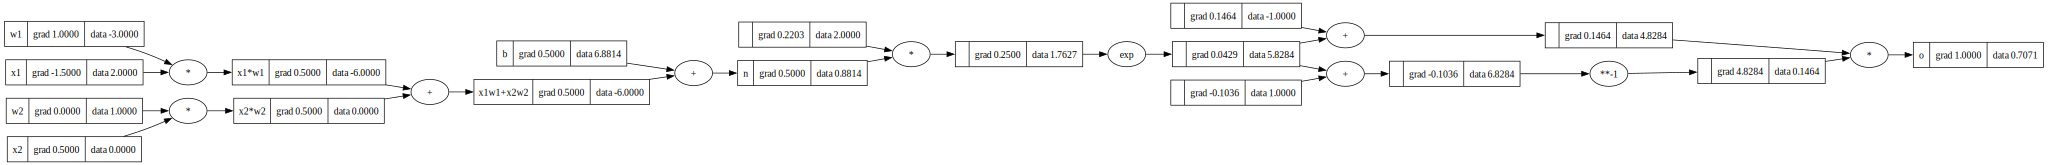

In [5]:
draw_dot(o)

In [6]:
import torch

In [7]:
x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.8813735870195433]); b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)
#----------
print(o.data.item())
o.backward()
#----------

0.7071066904050358


In [8]:
x1.grad.item()

-1.5000003851533106

In [9]:
import random
import numpy as np
class Neuron:
    def __init__(self, nin: int):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
        # self.w = [Value(-3.0),Value(1.0)]
        # self.b = Value(6.8813735870195433)
    
    def __call__(self, x):
        act = sum((xi*wi for xi,wi in zip(x,self.w)), Value(0))+self.b
        o = act.tanh()
        return o
    
    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin: int, nout: int):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self, nin, nouts):
        self.shapes = [nin]+nouts
        self.layers = [Layer(self.shapes[i],self.shapes[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x  
    
    def parameters(self):
        return [l for layer in self.layers for l in layer.parameters()]


In [10]:
t = Layer(2,3)
o = t([2.0,0.0])
o[0].grad=1.0
o[1].grad=1.0
o[2].grad=1.0
o[0].backward()
o[1].backward()
o[2].backward()
print(o)

[Value(data=-0.8556117624645938), Value(data=-0.43517353559309235), Value(data=0.4351050025467594)]


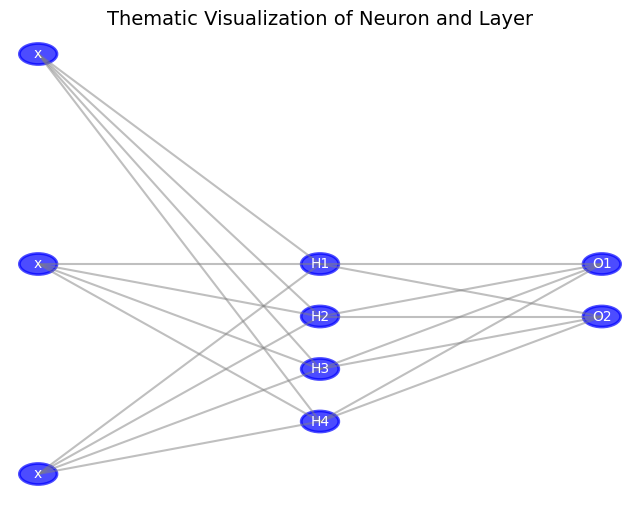

In [11]:
import matplotlib.pyplot as plt
import numpy as np

def plot_neuron(ax, x, y, size=0.2, label=None):
    """Draw a single neuron."""
    circle = plt.Circle((x, y), size, color='blue', alpha=0.7, lw=2)
    ax.add_artist(circle)
    if label:
        ax.text(x, y, label, color='white', fontsize=10, ha='center', va='center')

def plot_layer(ax, x, y, n_neurons, label_prefix="N", size=0.2, gap=1):
    """Draw a layer of neurons."""
    neurons = []
    for i in range(n_neurons):
        neuron_y = y - i * gap
        plot_neuron(ax, x, neuron_y, size=size, label=f"{label_prefix}{i+1}")
        neurons.append((x, neuron_y))
    return neurons

def plot_connections(ax, inputs, outputs):
    """Draw connections between two layers."""
    for x1, y1 in inputs:
        for x2, y2 in outputs:
            ax.plot([x1, x2], [y1, y2], 'gray', alpha=0.5)

def visualize_neuron_layer():
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.axis('off')

    # Input Layer
    inputs = [(0, y) for y in np.linspace(4, -4, 3)]
    for x, y in inputs:
        plot_neuron(ax, x, y, size=0.2, label=f"x")

    # Hidden Layer
    hidden = plot_layer(ax, 3, 0, n_neurons=4, label_prefix="H")

    # Output Layer
    output = plot_layer(ax, 6, 0, n_neurons=2, label_prefix="O")

    # Connections
    plot_connections(ax, inputs, hidden)
    plot_connections(ax, hidden, output)

    plt.title("Thematic Visualization of Neuron and Layer", fontsize=14)
    plt.show()

# Run the visualization
visualize_neuron_layer()


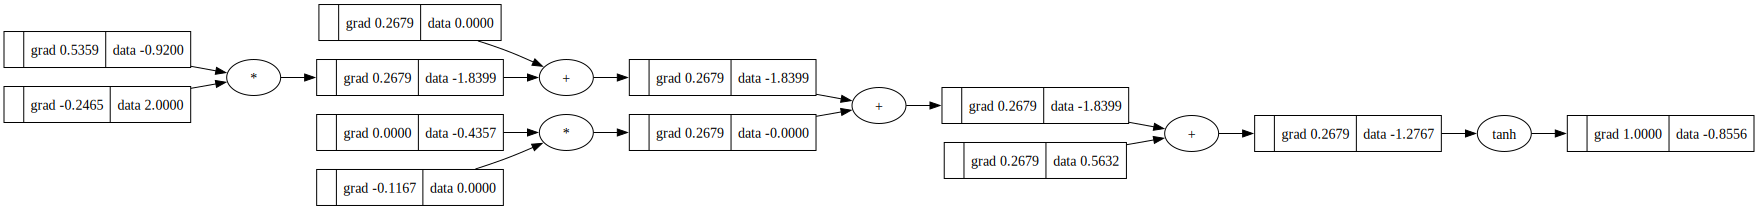

In [12]:
draw_dot(o[0])

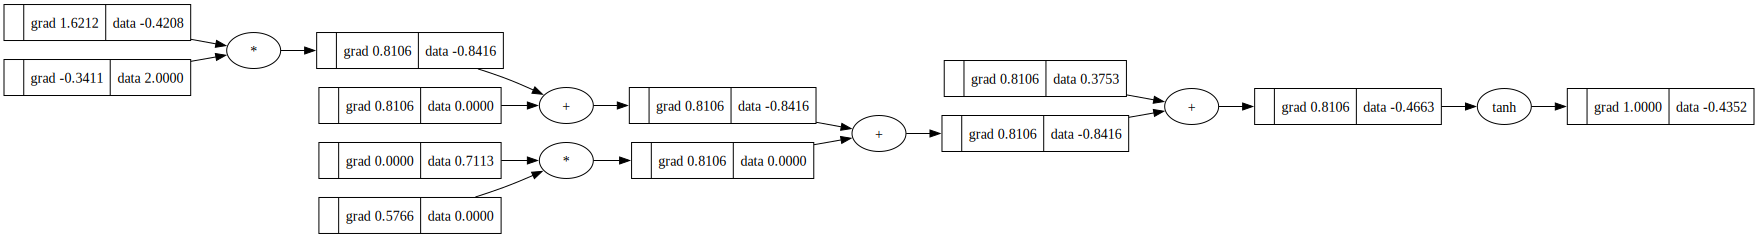

In [13]:
draw_dot(o[1])


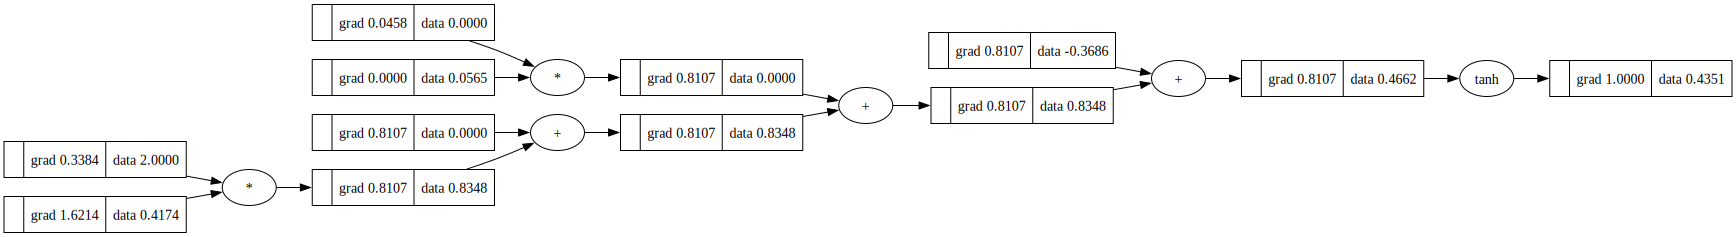

In [14]:
draw_dot(o[2])

In [15]:
n = MLP(2,[3,3,1])
o = n([2.0,0.0])
print(o)



[Value(data=-0.6933075904410552)]


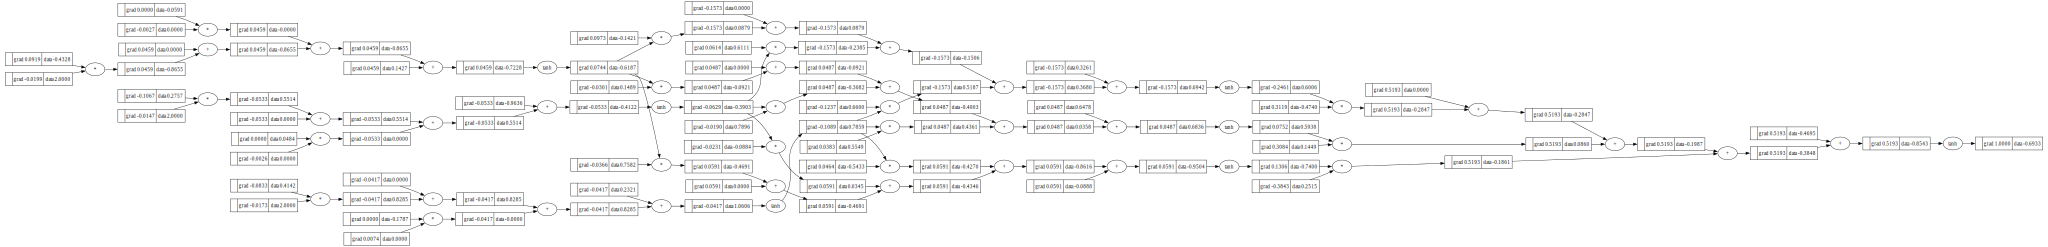

In [16]:
o[0].grad = 1
o[0].backward()
draw_dot(o[0])

In [17]:
n = MLP(3,[4,4,1])

In [29]:
# ----------------
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0,-1.0,-1.0,1.0] 


In [19]:
ypred = [n(x) for x in xs]

In [20]:
loss = sum(((x[0]-Value(y))**2 for x,y in zip(ypred,ys)), Value(0))
loss

Value(data=5.92966234766693)

In [21]:
[[Value(y)] for y in ys]

[[Value(data=1.0)], [Value(data=-1.0)], [Value(data=-1.0)], [Value(data=1.0)]]

In [22]:
loss.grad = 1.0
loss.backward()

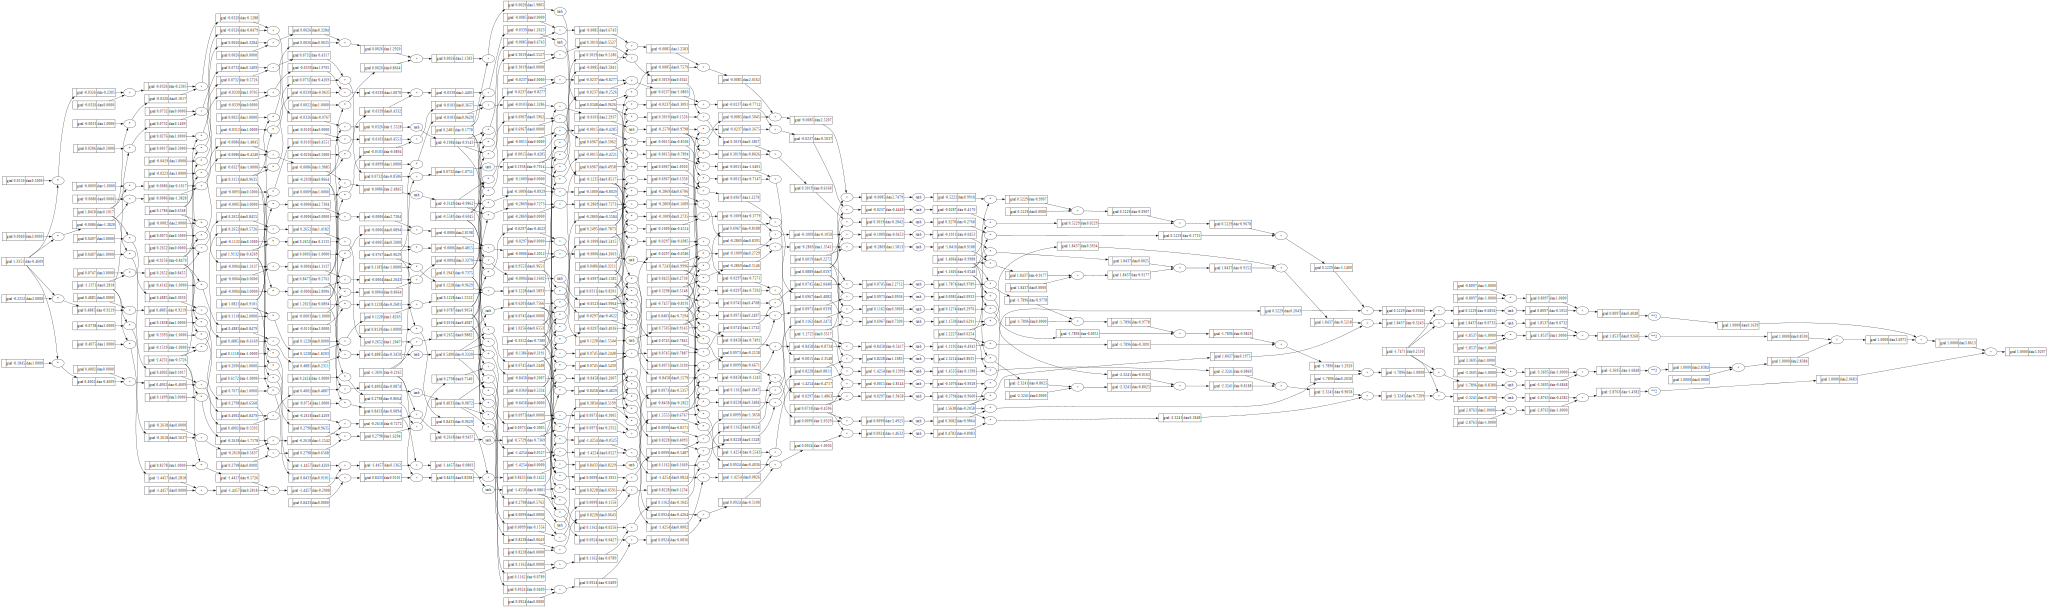

In [23]:
draw_dot(loss)

In [24]:
n.parameters()

[Value(data=-0.46094156635731753),
 Value(data=0.10166501074478873),
 Value(data=-0.8479422723340351),
 Value(data=-0.5760777789911309),
 Value(data=0.2818480480016272),
 Value(data=-0.5726154905109586),
 Value(data=-0.4269360838661913),
 Value(data=-0.21645097038896322),
 Value(data=0.6568322952599843),
 Value(data=0.9635460430656675),
 Value(data=0.866362800214564),
 Value(data=-0.17778510406412673),
 Value(data=0.9101354239063715),
 Value(data=-0.08935587830199787),
 Value(data=0.9629295467670944),
 Value(data=0.9650976321867819),
 Value(data=-0.7375153794491087),
 Value(data=-0.738044790861208),
 Value(data=0.7873104775101307),
 Value(data=0.5148355233804227),
 Value(data=0.22716636239770605),
 Value(data=0.9053615131388),
 Value(data=0.31913412303908184),
 Value(data=0.32106733790914843),
 Value(data=0.2730126117898757),
 Value(data=0.059699660581332026),
 Value(data=-0.6045070909747257),
 Value(data=0.655316503689886),
 Value(data=0.15850180069663788),
 Value(data=-0.819149835355

In [25]:
n.layers[1].neurons[1].b.data

0.059699660581332026

In [26]:
n.layers[1].neurons[1].b.grad

0.08885373118999379

In [27]:
l = 0.01
for p in n.parameters():
    p.data -=l*p.grad

In [28]:
n.parameters()

[Value(data=-0.4742922320332419),
 Value(data=0.08324666215983334),
 Value(data=-0.8386862042466718),
 Value(data=-0.5845530055559366),
 Value(data=0.2932191558231501),
 Value(data=-0.5483844976177641),
 Value(data=-0.4460682360624313),
 Value(data=-0.2027599049893694),
 Value(data=0.6550462445837564),
 Value(data=0.9603948972110015),
 Value(data=0.8693008632843379),
 Value(data=-0.1802657111318098),
 Value(data=0.8993141543197665),
 Value(data=-0.10137710338947793),
 Value(data=0.9726961907956728),
 Value(data=0.9555446547642141),
 Value(data=-0.7394579151632796),
 Value(data=-0.734732755402715),
 Value(data=0.7848154574468793),
 Value(data=0.5115376206468766),
 Value(data=0.22114721853235633),
 Value(data=0.904574119275849),
 Value(data=0.3205199618217656),
 Value(data=0.32058147934037906),
 Value(data=0.27257764814247326),
 Value(data=0.05881112326943209),
 Value(data=-0.5989259378040448),
 Value(data=0.6450600340386389),
 Value(data=0.16549924207794514),
 Value(data=-0.811693271497

In [31]:
lr = 0.05
for i in range(20):
    ypred = [n(x) for x in xs]
    loss = sum(((x[0]-Value(y))**2 for x,y in zip(ypred,ys)),Value(0))
    for p in n.parameters():
        p.grad = 0
    loss.grad = 1
    loss.backward()
    for p in n.parameters():
        p.data -= lr*p.grad
    print(i, loss.data) 

0 0.7465741000555521
1 0.32168641979246737
2 0.18871472831552982
3 0.13136509058540485
4 0.10003560749016256
5 0.08048951489007788
6 0.06720420023872145
7 0.0576187709649621
8 0.05039212420676043
9 0.044757184806406586
10 0.04024482930539511
11 0.03655266216571573
12 0.033477311629225626
13 0.030877135336082863
14 0.028650547734085798
15 0.026722851183086458
16 0.025037926101518174
17 0.023552814490544482
18 0.022234088651215653
19 0.021055355945825544
